In [336]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import os
os.environ["OMP_NUM_THREADS"] = '1'
torch.set_num_threads(4)
pyro.set_rng_seed(9)

In [337]:
def f(x):
    return torch.sin(20*x) +2*torch.cos(14*x) -2*torch.sin(6*x)

In [338]:
# define the gaussian process
X = torch.tensor([-1,-.5,0,.5,1])
y = f(X)
kernel = gp.kernels.RBF(input_dim=1)
gpr = gp.models.GPRegression(X, y, kernel,noise=torch.tensor(10**-4))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.), torch.tensor(2.0)))
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

In [339]:
# run MCMC sampler
num_chains=4
hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=500, num_chains=num_chains,
            mp_context='spawn', warmup_steps=10)
mcmc.run()
samples = mcmc.get_samples(group_by_chain=True)

Warmup [1]:   0%|          | 0/510 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/510 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/510 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/510 [00:00, ?it/s]

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.308  0.168   0.031    0.602      0.007    0.005   
kernel.variance     4.206  4.070   0.837    9.388      0.186    0.131   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     527.0     570.0   1.01  
kernel.variance        824.0     651.0   1.00  


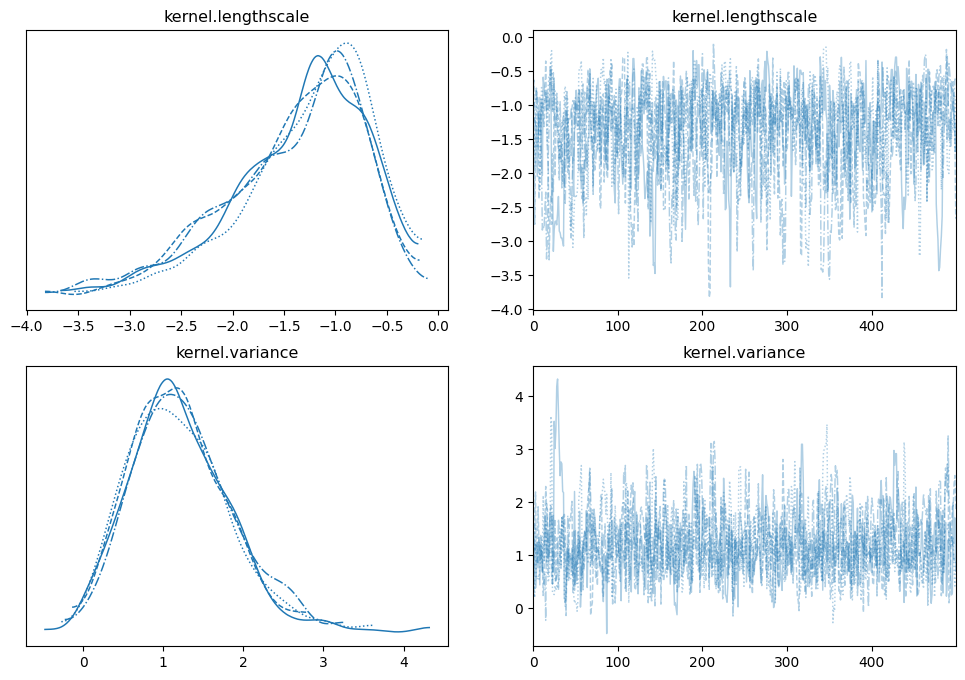

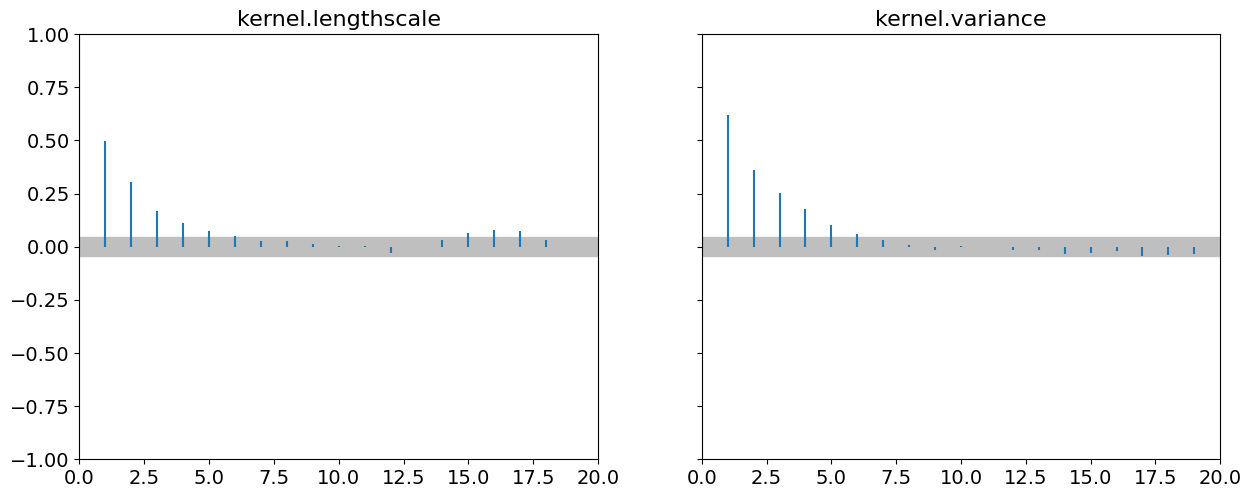

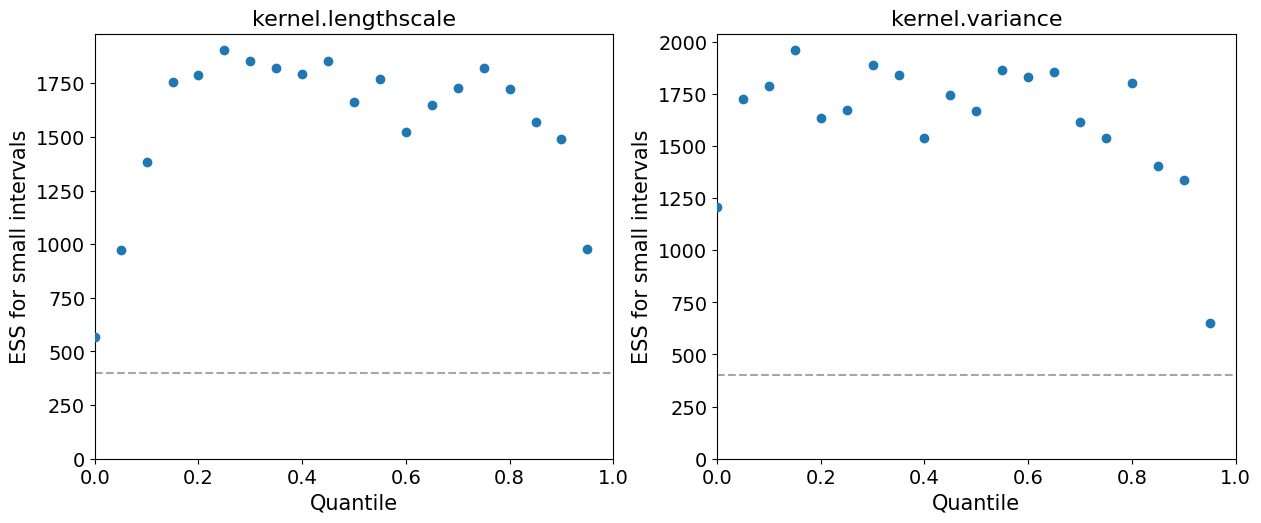

In [353]:
# inspect MCMC quality control metrics
print(az.summary(samples))
ax1= az.plot_trace(samples,transform=np.log,figsize=(12,8))
plt.savefig('MCMC_QC1.png')
az.plot_autocorr(samples,combined=True,max_lag=20,)
plt.savefig('MCMC_QC2.png')
az.plot_ess(samples,kind='local')
plt.savefig('MCMC_QC3.png')


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
       <AxesSubplot: title={'center': 'kernel.variance'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
      dtype=object)

In [342]:
#B.1.3 calculate mean and variance at each point by integrating over posterior samples
Xtest= torch.linspace(-1.0,1., 200)
subsample = mcmc.get_samples(500)
mean_list = []
var_list = []
for post_samp in range(0, 500):
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = subsample['kernel.variance'][post_samp]
    kernel.lengthscale = subsample['kernel.lengthscale'][post_samp]
    gpr_post = gp.models.GPRegression(X, y, kernel,noise=torch.tensor(0.0001))
    post_pred = gpr_post(Xtest,full_cov=False, noiseless=False)
    mean_list.append(post_pred[0])
    var_list.append(post_pred[1])

In [343]:
mean = sum(mean_list)/len(mean_list)
var = (sum(var_list) + sum([i**2 for i in mean_list]))/len(var_list) - mean**2

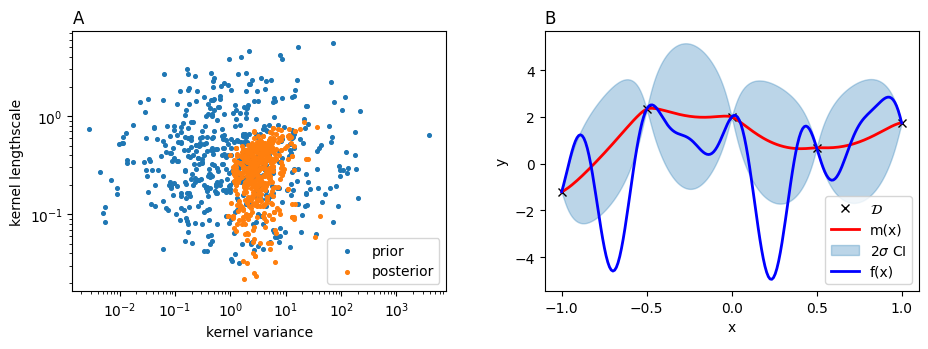

In [351]:
# B.1.(1/3)
fig, (ax1,ax2) = plt.subplots(figsize=(10, 4), ncols=2)
fig.tight_layout(pad=4)
ax1.set_title('A', loc='left')
priorlen = dist.LogNormal(-1,1).sample(sample_shape=(500,))
priorvar = dist.LogNormal(0,2).sample(sample_shape=(500,))
ax1.scatter(priorvar, priorlen, s=7, label='prior')
ax1.scatter(subsample['kernel.variance'],
            subsample['kernel.lengthscale'], s=7, label='posterior')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('kernel variance')
ax1.set_ylabel('kernel lengthscale')
ax1.legend()

ax2.set_title('B', loc='left')
with torch.no_grad():
    ax2.plot(X.numpy(), y.numpy(), "kx", label='$\mathcal{D}$')
    sd = var.sqrt()  # standard deviation at each input point x
    ax2.plot(Xtest.numpy(), mean.numpy(), "r", lw=2, label='m(x)')  # plot the mean
    ax2.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
            label='2$\sigma$ CI'
        )
ax2.plot(Xtest, f(Xtest), "b", lw=2, label='f(x)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend(loc= 'lower right')

plt.savefig('GP.png')
plt.show()

In [404]:
def bayesian_opt(X,y,loss_method, kappa=2):
    global seed
    # estimate  theta|X,y
    print(i)
    for attempt in range(0,5):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        gpr_opt = gp.models.GPRegression(X, y, kernel,noise=torch.tensor(10**-4))
        hmc_kernel = NUTS(gpr_opt.model)#, jit_compile=True)
        mcmc = MCMC(hmc_kernel, num_samples=100, num_chains=1,
                mp_context='spawn', warmup_steps=10, disable_progbar=False)
        mcmc.run()
        diagn = mcmc.diagnostics()
        if (diagn['kernel.variance']['r_hat']<=1.05) & (diagn['kernel.variance']['r_hat']<=1.05):
            break
        seed+=1
        pyro.set_rng_seed(seed)
    else:
        raise Exception('No convergence after 5 attempts.')

    posterior = mcmc.get_samples(1)
    # calculate p(f*|X*,theta)
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = posterior['kernel.variance']
    kernel.lengthscale = posterior['kernel.lengthscale']
    gpr_opt = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**-4))
    mean, cov = gpr_opt(Xtest, full_cov=True, noiseless=False)
    cov += 1e-3 * torch.eye(len(Xtest)) # provides numerical stability

    # sample f*
    fstar = dist.MultivariateNormal(
        mean, covariance_matrix=cov, 
    ).sample()
    # find argmin f*
    if loss_method=='fmin':
        Xstar = Xtest[torch.argmin(fstar)]
    elif loss_method=='LCM':
        LCB = mean - kappa*sd
        Xstar = Xtest[torch.argmin(LCB)]
    else:
        raise Exception('Loss method must be one of "fmin" or "LCM".')
    X = torch.cat((X, Xstar.reshape(1)))
    y = f(X)
    seed+=1
    pyro.set_rng_seed(seed)
    return(X,y,mean,cov,Xstar,fstar)

def bay_opt_plot(X,y,mean,cov,Xstar,fstar, timestep, ax):
    ax.plot(Xtest.numpy(), fstar.numpy().T, lw=2, alpha=0.4, label='f*(x)')
    ax.plot(Xtest.numpy(), f(Xtest), lw=2, alpha=0.4, label='f(x)')
    ax.plot(X.numpy(), y.numpy(), "kx", label='$\mathcal{D}$')
    sd = cov.diag().sqrt()  # standard deviation at each input point x
    ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2, label='m(x)')  # plot the mean
    ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
            label='2$\sigma$ CI'
    )
    ax.plot(Xstar.numpy(), f(Xstar).numpy(), "bo", markersize=10, label='$(x^*_p, f(x^*_p)$')
    ax.legend(loc='upper left',prop={'size': 6})
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Iteration: {timestep}", loc='left')

0


Sample: 100%|██████████| 110/110 [00:02, 37.39it/s, step size=2.22e-01, acc. prob=0.933]


Iteration: 0
1


Sample: 100%|██████████| 110/110 [00:02, 45.17it/s, step size=2.98e-01, acc. prob=0.851]


2


Sample: 100%|██████████| 110/110 [00:02, 37.18it/s, step size=2.03e-01, acc. prob=0.939]


3


Sample: 100%|██████████| 110/110 [00:09, 11.94it/s, step size=6.80e-02, acc. prob=0.986]


4


Sample: 100%|██████████| 110/110 [00:01, 64.49it/s, step size=3.57e-01, acc. prob=0.762]


5


Sample: 100%|██████████| 110/110 [00:02, 45.93it/s, step size=2.69e-01, acc. prob=0.852]


Iteration: 5
6


Sample: 100%|██████████| 110/110 [00:02, 38.35it/s, step size=1.88e-01, acc. prob=0.835]


7


Sample: 100%|██████████| 110/110 [00:03, 28.22it/s, step size=1.13e-01, acc. prob=0.917]


8


Sample: 100%|██████████| 110/110 [00:15,  7.08it/s, step size=1.87e-02, acc. prob=0.983]


9


Sample: 100%|██████████| 110/110 [00:18,  6.05it/s, step size=1.37e-02, acc. prob=0.986]


10


Sample: 100%|██████████| 110/110 [00:03, 34.12it/s, step size=1.06e-01, acc. prob=0.935]


Iteration: 10


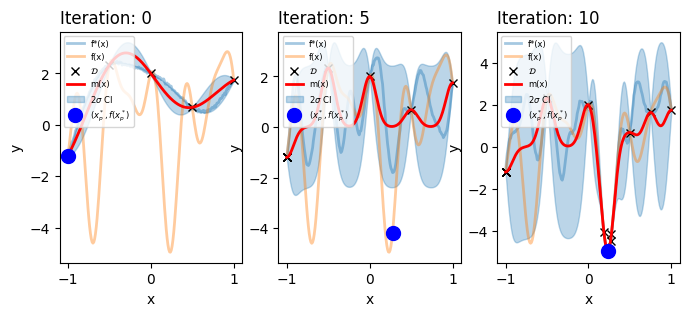

In [406]:
# make progression plot for B.2.1
seed=1
Xtest= torch.linspace(-1., 1, 200)
loss_method = 'fmin'
fig, ax = plt.subplots(figsize=(8, 3),ncols=3)
X = torch.tensor([-1,-.5,0,.5,1])
y = f(X)
for i in range(0,11):
    X,y,mean,cov,Xstar,fstar = bayesian_opt(X,y,loss_method, kappa=2)    
    pyro.set_rng_seed(seed)
    # plot
    if i%5 == 0:
        n = i//5
        with torch.no_grad():
            bay_opt_plot(X,y,mean,cov,Xstar,fstar, timestep=i, ax=ax[n])
plt.savefig(f'bayopt.png')

0


Sample: 100%|██████████| 110/110 [00:03, 35.19it/s, step size=2.22e-01, acc. prob=0.933]


1


Sample: 100%|██████████| 110/110 [00:02, 44.23it/s, step size=2.98e-01, acc. prob=0.851]


2


Sample: 100%|██████████| 110/110 [00:03, 36.34it/s, step size=2.03e-01, acc. prob=0.939]


3


Sample: 100%|██████████| 110/110 [00:09, 11.90it/s, step size=6.80e-02, acc. prob=0.986]


4


Sample: 100%|██████████| 110/110 [00:01, 69.83it/s, step size=3.57e-01, acc. prob=0.762]


5


Sample: 100%|██████████| 110/110 [00:02, 47.60it/s, step size=2.69e-01, acc. prob=0.852]


6


Sample: 100%|██████████| 110/110 [00:02, 37.12it/s, step size=1.88e-01, acc. prob=0.835]


7


Sample: 100%|██████████| 110/110 [00:04, 26.54it/s, step size=1.13e-01, acc. prob=0.917]


8


Sample: 100%|██████████| 110/110 [00:19,  5.51it/s, step size=1.87e-02, acc. prob=0.983]


9


Sample: 100%|██████████| 110/110 [00:23,  4.59it/s, step size=1.37e-02, acc. prob=0.986]


10


Sample: 100%|██████████| 110/110 [00:03, 33.36it/s, step size=1.06e-01, acc. prob=0.935]


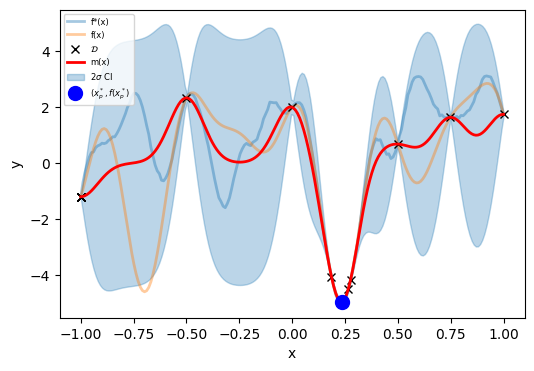

0


Sample: 100%|██████████| 110/110 [00:03, 36.33it/s, step size=2.22e-01, acc. prob=0.933]


1


Sample: 100%|██████████| 110/110 [00:03, 35.96it/s, step size=2.21e-01, acc. prob=0.903]


2


Sample: 100%|██████████| 110/110 [00:02, 47.18it/s, step size=2.97e-01, acc. prob=0.937]


3


Sample: 100%|██████████| 110/110 [00:07, 14.86it/s, step size=7.34e-02, acc. prob=0.984]


4


Sample: 100%|██████████| 110/110 [04:36,  2.52s/it, step size=1.28e-03, acc. prob=0.985]


5


Sample: 100%|██████████| 110/110 [00:03, 34.10it/s, step size=1.38e-01, acc. prob=0.975]


6


Sample: 100%|██████████| 110/110 [00:03, 27.77it/s, step size=1.14e-01, acc. prob=0.974]


7


Sample: 100%|██████████| 110/110 [01:58,  1.08s/it, step size=3.24e-03, acc. prob=0.990]


8


Sample: 100%|██████████| 110/110 [00:05, 18.47it/s, step size=8.44e-02, acc. prob=0.981]


9


Sample: 100%|██████████| 110/110 [00:02, 38.73it/s, step size=1.45e-01, acc. prob=0.907]


10


Sample: 100%|██████████| 110/110 [00:31,  3.50it/s, step size=1.38e-06, acc. prob=0.001]


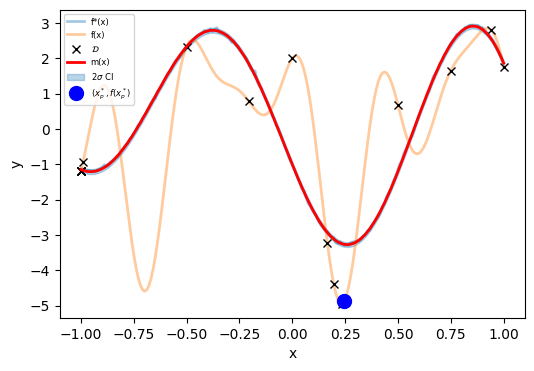

0


Sample: 100%|██████████| 110/110 [00:02, 44.48it/s, step size=2.64e-01, acc. prob=0.891]


1


Sample: 100%|██████████| 110/110 [00:03, 34.06it/s, step size=1.81e-01, acc. prob=0.948]


2


Sample: 100%|██████████| 110/110 [00:02, 40.50it/s, step size=1.99e-01, acc. prob=0.895]


3


Sample: 100%|██████████| 110/110 [00:03, 29.54it/s, step size=1.33e-01, acc. prob=0.968]


4


Sample: 100%|██████████| 110/110 [00:03, 28.19it/s, step size=1.30e-01, acc. prob=0.965]


5


Sample: 100%|██████████| 110/110 [00:02, 38.05it/s, step size=1.90e-01, acc. prob=0.946]


6


Sample: 100%|██████████| 110/110 [00:01, 61.28it/s, step size=2.54e-01, acc. prob=0.791]


7


Sample: 100%|██████████| 110/110 [05:07,  2.79s/it, step size=5.87e-04, acc. prob=0.999]


8


Sample: 100%|██████████| 110/110 [00:01, 61.03it/s, step size=2.01e-01, acc. prob=0.732]


9


Sample: 100%|██████████| 110/110 [05:37,  3.07s/it, step size=5.61e-05, acc. prob=0.743]


10


Sample: 100%|██████████| 110/110 [02:02,  1.12s/it, step size=2.13e-03, acc. prob=0.984]


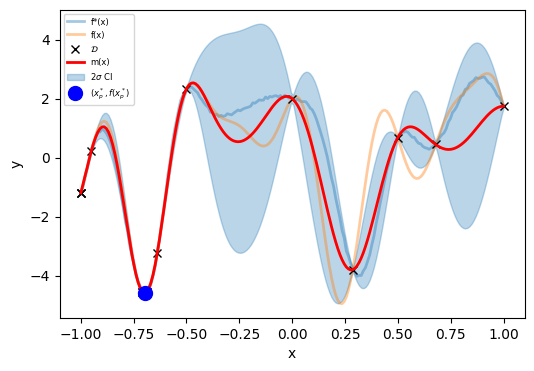

0


Sample: 100%|██████████| 110/110 [00:01, 91.85it/s, step size=5.74e-01, acc. prob=0.595]


1


Sample: 100%|██████████| 110/110 [00:05, 19.54it/s, step size=1.05e-01, acc. prob=0.984]


2


Sample: 100%|██████████| 110/110 [00:04, 26.68it/s, step size=1.50e-01, acc. prob=0.980]


3


Sample: 100%|██████████| 110/110 [00:01, 79.83it/s, step size=4.99e-01, acc. prob=0.690]


4


Sample: 100%|██████████| 110/110 [00:02, 54.76it/s, step size=3.01e-01, acc. prob=0.817]


5


Sample: 100%|██████████| 110/110 [00:28,  3.83it/s, step size=1.76e-02, acc. prob=0.993]


6


Sample: 100%|██████████| 110/110 [04:55,  2.68s/it, step size=1.20e-03, acc. prob=0.997]


7


Sample: 100%|██████████| 110/110 [00:03, 35.03it/s, step size=1.54e-01, acc. prob=0.899]


8


Sample: 100%|██████████| 110/110 [00:02, 49.75it/s, step size=2.04e-01, acc. prob=0.829]


9


Sample: 100%|██████████| 110/110 [00:03, 34.53it/s, step size=1.37e-01, acc. prob=0.910]


10


Sample: 100%|██████████| 110/110 [00:02, 47.98it/s, step size=1.56e-01, acc. prob=0.806]


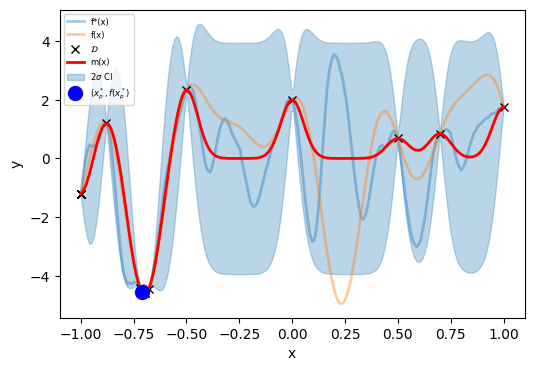

0


Sample: 100%|██████████| 110/110 [00:01, 79.63it/s, step size=5.47e-01, acc. prob=0.727]


1


Sample: 100%|██████████| 110/110 [00:02, 37.89it/s, step size=2.28e-01, acc. prob=0.904]


2


Sample: 100%|██████████| 110/110 [00:02, 50.67it/s, step size=3.05e-01, acc. prob=0.811]


3


Sample: 100%|██████████| 110/110 [00:02, 43.84it/s, step size=2.54e-01, acc. prob=0.903]


4


Sample: 100%|██████████| 110/110 [00:05, 20.44it/s, step size=1.14e-01, acc. prob=0.984]


5


Sample: 100%|██████████| 110/110 [00:03, 34.07it/s, step size=1.92e-01, acc. prob=0.925]


6


Sample: 100%|██████████| 110/110 [00:01, 58.54it/s, step size=3.41e-01, acc. prob=0.708]


7


Sample: 100%|██████████| 110/110 [00:06, 16.30it/s, step size=9.64e-02, acc. prob=0.980]


8


Sample: 100%|██████████| 110/110 [00:06, 15.75it/s, step size=7.78e-02, acc. prob=0.974]


9


Sample: 100%|██████████| 110/110 [00:03, 28.47it/s, step size=9.91e-02, acc. prob=0.702]


10


Sample: 100%|██████████| 110/110 [02:08,  1.16s/it, step size=2.58e-03, acc. prob=0.938]


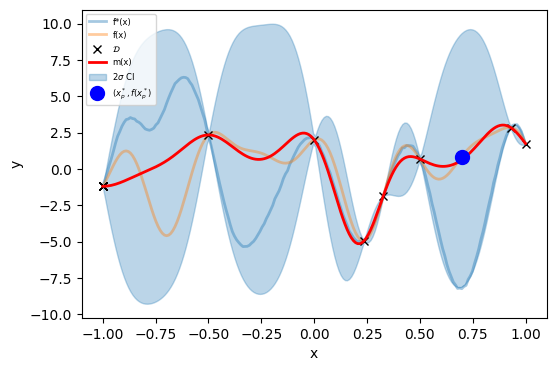

0


Sample: 100%|██████████| 110/110 [00:04, 24.82it/s, step size=1.27e-01, acc. prob=0.984]


1


Sample: 100%|██████████| 110/110 [00:01, 72.99it/s, step size=4.27e-01, acc. prob=0.667]


2


Sample: 100%|██████████| 110/110 [00:08, 13.15it/s, step size=5.12e-02, acc. prob=0.996]


3


Sample: 100%|██████████| 110/110 [02:46,  1.52s/it, step size=1.37e-04, acc. prob=0.578]


4


Sample: 100%|██████████| 110/110 [00:03, 32.67it/s, step size=1.16e-01, acc. prob=0.883]


5


Sample: 100%|██████████| 110/110 [00:03, 31.64it/s, step size=1.36e-01, acc. prob=0.971]


6


Sample: 100%|██████████| 110/110 [00:02, 42.48it/s, step size=2.01e-01, acc. prob=0.907]


7


Sample: 100%|██████████| 110/110 [00:01, 55.83it/s, step size=2.03e-01, acc. prob=0.824]


8


Sample: 100%|██████████| 110/110 [00:02, 41.61it/s, step size=1.27e-01, acc. prob=0.896]


9


Sample: 100%|██████████| 110/110 [00:03, 31.25it/s, step size=8.47e-02, acc. prob=0.954]


10


Sample: 100%|██████████| 110/110 [00:02, 46.24it/s, step size=1.26e-01, acc. prob=0.879]


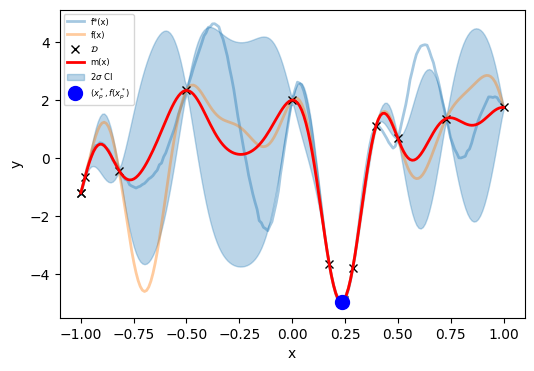

0


Sample: 100%|██████████| 110/110 [00:01, 61.62it/s, step size=4.28e-01, acc. prob=0.777]


1


Sample: 100%|██████████| 110/110 [00:18,  5.83it/s, step size=2.41e-02, acc. prob=1.000]


2


Sample: 100%|██████████| 110/110 [00:02, 46.02it/s, step size=2.75e-01, acc. prob=0.896]


3


Sample: 100%|██████████| 110/110 [00:02, 43.61it/s, step size=2.19e-01, acc. prob=0.943]


4


Sample: 100%|██████████| 110/110 [00:53,  2.05it/s, step size=7.21e-03, acc. prob=0.995]


5


Sample: 100%|██████████| 110/110 [00:06, 16.26it/s, step size=4.70e-02, acc. prob=0.989]


6


Sample: 100%|██████████| 110/110 [00:02, 47.95it/s, step size=1.70e-01, acc. prob=0.830]


7


Sample: 100%|██████████| 110/110 [00:08, 13.18it/s, step size=3.40e-02, acc. prob=0.988]


8


Sample: 100%|██████████| 110/110 [00:11,  9.63it/s, step size=2.33e-02, acc. prob=0.991]


9


Sample: 100%|██████████| 110/110 [00:03, 29.10it/s, step size=8.68e-02, acc. prob=0.973]


10


Sample: 100%|██████████| 110/110 [00:01, 56.59it/s, step size=2.01e-01, acc. prob=0.725]


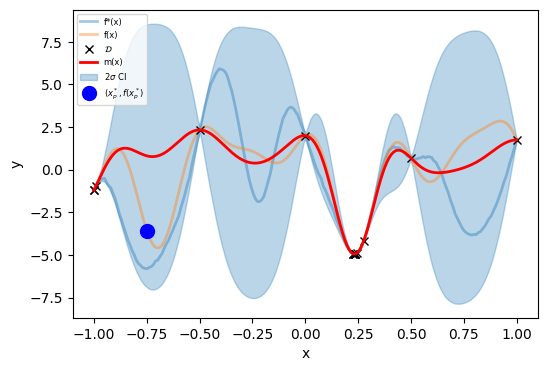

0


Sample: 100%|██████████| 110/110 [00:01, 64.83it/s, step size=3.89e-01, acc. prob=0.721]


1


Sample: 100%|██████████| 110/110 [00:03, 29.38it/s, step size=1.64e-01, acc. prob=0.956]


2


Sample: 100%|██████████| 110/110 [04:18,  2.35s/it, step size=1.22e-04, acc. prob=0.639]


Exception: No convergence after 5 attempts.

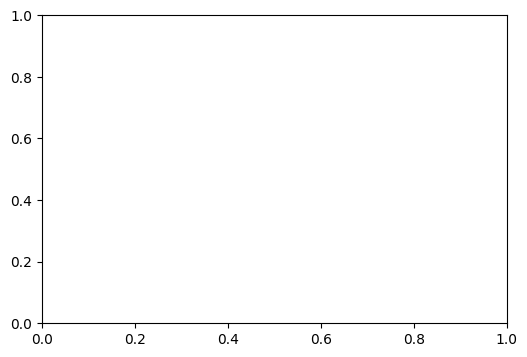

In [394]:
seed=1
X = torch.tensor([-1,-.5,0,.5,1])
y = f(X)
Xtest= torch.linspace(-1., 1, 200)
loss_method = 'fmin'
for j in range(0,10):
    loss_method = 'fmin'
    fig, ax = plt.subplots(figsize=(6,4),nrows=1)
    X = torch.tensor([-1,-.5,0,.5,1])
    y = f(X)
    for i in range(0,11):
        X,y,mean,cov,Xstar,fstar = bayesian_opt(X,y,loss_method, kappa=2)    
        pyro.set_rng_seed(seed)
        # plot
        if i== 10:
            with torch.no_grad():
                bay_opt_plot(X,y,mean,cov,Xstar,fstar, ax)
    plt.savefig(f'PML_finals/bayopt{j}.png')
    plt.show()
for j in range(0,10):
    loss_method = 'LCM'
    fig, ax = plt.subplots(figsize=(6, 4),nrows=1)
    X = torch.tensor([-1,-.5,0,.5,1])
    y = f(X)
    for i in range(0,11):
        X,y,mean,cov,Xstar,fstar = bayesian_opt(X,y,loss_method, kappa=2)    
        pyro.set_rng_seed(seed)
        # plot
        if i == 10:
            n = i//5
            with torch.no_grad():
                bay_opt_plot(X,y,mean,cov,Xstar,fstar, ax)
    plt.savefig(f'PML_finals/bayopt_LCM{j}.png')
    plt.show()

In [393]:
y

tensor([-1.1983,  2.3341,  2.0000,  0.6815,  1.7453, -1.1983, -1.1983, -1.1983,
        -1.1983, -1.1983, -4.1714, -4.4816, -4.0587,  1.6391, -4.9358, -4.9492])